In [266]:
import netCDF4
import numpy as np
import pyvista as pv
import vtk
import matplotlib.pyplot as plt
from pyvista.core.filters.data_set import DataSetFilters
import scipy.integrate as integrate
import os
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import string

import matplotlib
from matplotlib import rcParams
import matplotlib.transforms as mtrans
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

from glob import glob

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

figdir = './figures/'

In [396]:

BIGGER_SIZE = 20
MEDIUM_SIZE = 18
SMALL_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [194]:

##############################################################################
# read n'th step data and write into PyVista UnstructuredGrid
# By Yan Zhan (2022)
# Input: fname = string (file name)
#        nstep (int):  the time step
# output: PyVista UnstructuredGrid Data
def exodus2PyVista(filename, nstep=-1):
    # read exodus by netCFD4
    model = netCDF4.Dataset(filename)
    # print(model)
    # read coordinates
    X_all = np.ma.getdata(model.variables['coordx'][:])
    Y_all = np.ma.getdata(model.variables['coordy'][:])
    Z_all = np.ma.getdata(model.variables['coordz'][:])
    # ensemble the points
    points = np.vstack([X_all,Y_all,Z_all]).T
    # how node is mapped
    elem_node = np.ma.getdata(model.variables['connect1'][:])-1

    n_elements = elem_node.shape[0]
    # cells = np.hstack([np.full((n_elements, 1), 4), elem_node]).flatten()

# Define the cell type for tetrahedrons in VTK
    # cell_type = np.full(n_elements, pv.CellType.VTK_LINE)


    # create PyVista UnstructuredGrid
    grid = pv.UnstructuredGrid({vtk.VTK_LINE: elem_node}, points)
    # grid = pv.UnstructuredGrid(cells, cell_type, points)
    # cell_types = np.full(elem_node.shape[0], vtk.VTK_LINE)
    # connectivity = np.c_[np.full(elem_node.shape[0], 2), elem_node]
    # grid = pv.UnstructuredGrid(cell_types, connectivity, points)
    
    # get the name of the variables
    name_nod_var = getNames(model,'name_nod_var') #nodal data 
    name_elem_var = getNames(model,'name_elem_var') #element data
    # print('name_nod_var = ', name_nod_var)
    # print('name_elem_var = ', name_elem_var)
    # write the data in the PyVista mesh (nodal)
    # print('nsteps = ', len(model.variables['vals_nod_var1'][:]))
    for i, nnv in enumerate(name_nod_var):
        grid[nnv] = model.variables['vals_nod_var{}'.format(i+1)][:][nstep]
    # write the data in the PyVista mesh (element)
    for i, nev in enumerate(name_elem_var):
        grid[nev] = model.variables['vals_elem_var{}eb1'.format(i+1)][:][nstep]
    # close the model
    model.close()
    
    return grid

##############################################################################
# Get Names in a catalog (key)
# By Yan Zhan (2022)
def getNames(model, key='name_nod_var'):
    # name of the element variables
    name_var = []
    for vname in np.ma.getdata(model.variables[key][:]).astype('U8'):
        name_var.append(''.join(vname))
    return name_var

In [502]:
# mesh = exodus2PyVista('/Users/zeeshan/projects/edl_solid/test/tests/test-llzo5_out.e-s004', 1)

L_scaling = 1.00E-07
eps_scaling = 1.50E-12

echarge = 4.140E+01
kTbye = 1
# kT = ${fparse e*kTbye}
dfepos = 1.935E+01
Bpos = 0 # -0.3
etapos = 0 # 0.0003
dfeneg = dfepos # 37.53478261 # in J/e = eV
Bneg = 0 #-0.3
etaneg = 0 #  0.0003
N = 5.000E+07
epsr = 10.0
eps0 = 5.913E+00
V0 = 3.870E+00
L = 1.900E+01
c0 = np.exp(-(dfepos+dfeneg)/2/kTbye)
alpha = 0.1
fp = 0 #65.
fm = 0 #65.
fpm = 0.0
Ld = np.sqrt(epsr*eps0*kTbye/2/echarge/N/c0)
lambda_c = 0.3E-10

V_scaling = 2.58E-02

def compare_nmesh(files, legends,  xscale = 'log', yscale = 'linear', linestyles = None, subplotlabel = None):
    phis = []
    cposs = []
    cnegs = []
    xdatas = []
    grad_phi_xs = []
    xdatas_cells = []
    rhos = []
    capcs = []
    integrals_conc_pos = np.zeros(len(files))
    integrals_conc_neg = np.zeros(len(files))
    if linestyles is None:
        linestyles = ['-' for i in range(len(files))]
    for fname in files:
        mesh = exodus2PyVista(fname, -1)
        phi = mesh.point_data['phi'] * V_scaling
        cneg = mesh.point_data['cneg'] * c0
        cpos = mesh.point_data['cpos'] * c0
        grad_phi_x = mesh.point_data['grad_phi_x'] * V_scaling/L_scaling
        eps = mesh.cell_data['eps'][0] * eps_scaling
        mu0_pos = mesh.cell_data['mu0_pos'][-1] * V_scaling
        
        xdata = mesh.points[:, 0] * L_scaling # in m
        indices = np.argsort(xdata)
        xdata_sorted = xdata[indices]
        xdatas.append(xdata_sorted)
        phis.append(phi[indices])
        cnegs.append(cneg[indices])
        cposs.append(cpos[indices])
        grad_phi_xs.append(grad_phi_x[indices])

        rho = mesh.cell_data['rhobyeps'] * eps
        xdata_cells = mesh.cell_centers().points[:, 0] * L_scaling       # (xdata[:-1] + xdata[1:])/2
        indices_cell = np.argsort(xdata_cells)
        xdatas_cells.append(xdata_cells[indices_cell])
        rhos.append(rho[indices_cell])
        

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax = ax.flat
    if subplotlabel:
        for n, axin in enumerate(ax):
            axin.text(-0.22, 0.95, '('+subplotlabel[n]+   ')', transform=axin.transAxes, size=20)
    else:
        pass
        #for n, axin in enumerate(ax):
        #    axin.text(-0.22, 0.95, '('+string.ascii_lowercase[n]+')', transform=axin.transAxes, size=20)
    for i, fname in enumerate(files):
        # capcs.append(-grad_phi_xs[i][0] * eps / np.abs(phis[i][0]) )
        # print('surface concs = ', cposs[i][0], cnegs[i][0])
        filename = os.path.basename(fname)
        print('---------Case-----------', filename)
        print('length = ', xdatas[i][-1])
        
        print('Bulk values: phi = {:1.4f} V, cpos = {:1.3e}, cneg = {:1.3e}'.format(phis[i][-1], cposs[i][-1], cnegs[i][-1]))
        ax[0].plot(xdatas[i], phis[i], label = legends[i], alpha = 0.6, linewidth=4, linestyle=linestyles[i])
        # ax[1].plot(xdatas[i], cposs[i], label = legends[i])
        # ax[1].plot(xdatas[i], cnegs[i])
        
        line, = ax[1].plot(xdatas[i], cposs[i], label=legends[i], linestyle='-', linewidth=4,  alpha = 0.6)
        color = line.get_color()  # Get the color used for cposs
        # Plot cnegs with the same color but a dashed line
        ax[1].plot(xdatas[i], cnegs[i], color=color, linestyle='--', alpha = 0.6, linewidth=4)
        
        # ax[2].plot(xdatas_cells[i], rhos[i], label = legends[i])
        # ax[3].plot(xdatas[i], grad_phi_xs[i], label = legends[i])
    integrals_conc_pos = [np.trapezoid(cposs[i], xdatas[i]) for i in range(len(phis))]
    integrals_conc_neg = [np.trapezoid(cnegs[i], xdatas[i]) for i in range(len(phis))]
    capcs = np.array([grad_phi_xs[i][0] * eps / np.abs(phis[i][0]) for i in range(len(phis))])
    surf_charges = np.array([-grad_phi_xs[i][0] * eps for i in range(len(phis))])
    # print('surface charges (C/m2) = ', surf_charges)
    # print('surface charges (e/nm2) = ', surf_charges/1.602e-19 * 1e-18)
    surf_concs = [cposs[i][0] for i in range(len(phis))]
    
    ax[0].set_ylabel(r'Potential (V)')
    ax[1].set_ylabel(r'Defect concentration $c$')
    ax[1].set_yscale(yscale)
    # ax[2].set_yscale(yscale)
    # ax[3].set_yscale(yscale)
    for axin in ax:
        axin.set_xscale(xscale)
        axin.set_xlabel('x (m)')
#        axin.set_yscale('log')
    ax[0].legend(frameon = False) #, loc = 'upper left'
    # ax[1].legend(frameon = False, loc = 'upper right')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()

    stats = {}
    stats['surf_charges'] = surf_charges
    stats['capcs'] = capcs
    stats['surf_concs'] = surf_concs
    stats['integrals_conc_pos'] = integrals_conc_pos
    stats['integrals_conc_neg'] = integrals_conc_neg
    # fig.savefig(figname, bbox_inches='tight', transparent=True, dpi=600)
    return (fig, ax, stats)


def stats_nmesh(files):
    phis = []
    cposs = []
    cnegs = []
    xdatas = []
    grad_phi_xs = []
    xdatas_cells = []
    rhos = []
    capcs = []
    integrals_conc_pos = np.zeros(len(files))
    integrals_conc_neg = np.zeros(len(files))
    for fname in files:
        mesh = exodus2PyVista(fname, -1)
        phi = mesh.point_data['phi'] * V_scaling
        cneg = mesh.point_data['cneg'] * c0
        cpos = mesh.point_data['cpos'] * c0
        grad_phi_x = mesh.point_data['grad_phi_x'] * V_scaling/L_scaling
        eps = mesh.cell_data['eps'][0] * eps_scaling
        mu0_pos = mesh.cell_data['mu0_pos'][-1] * V_scaling
        
        xdata = mesh.points[:, 0] * L_scaling # in m
        indices = np.argsort(xdata)
        xdata_sorted = xdata[indices]
        xdatas.append(xdata_sorted)
        phis.append(phi[indices])
        cnegs.append(cneg[indices])
        cposs.append(cpos[indices])
        grad_phi_xs.append(grad_phi_x[indices])

        rho = mesh.cell_data['rhobyeps'] * eps
        xdata_cells = mesh.cell_centers().points[:, 0] * L_scaling       # (xdata[:-1] + xdata[1:])/2
        indices_cell = np.argsort(xdata_cells)
        xdatas_cells.append(xdata_cells[indices_cell])
        rhos.append(rho[indices_cell])
    icore = [np.argmin(np.abs(xdatas[i] - lambda_c)) for i in range(len(files))]
    integrals_conc_pos = [np.trapezoid(cposs[i], xdatas[i]) for i in range(len(phis))]
    integrals_conc_neg = [np.trapezoid(cnegs[i], xdatas[i]) for i in range(len(phis))]
    integrals_conc_pos_core = [np.trapezoid(cposs[i][:icore[i]], xdatas[i][:icore[i]]) for i in range(len(phis))]
    integrals_conc_neg_core = [np.trapezoid(cnegs[i][:icore[i]], xdatas[i][:icore[i]]) for i in range(len(phis))]
    capcs = np.array([grad_phi_xs[i][0] * eps / np.abs(phis[i][0]) for i in range(len(phis))])
    surf_charges = np.array([-grad_phi_xs[i][0] * eps for i in range(len(phis))])
    surf_concs = [cposs[i][0] for i in range(len(phis))]

    stats = {}
    stats['surf_charges'] = surf_charges
    stats['capcs'] = capcs
    stats['surf_concs'] = surf_concs
    stats['integrals_conc_pos'] = integrals_conc_pos
    stats['integrals_conc_neg'] = integrals_conc_neg
    stats['integrals_conc_pos_core'] = integrals_conc_pos_core
    stats['integrals_conc_neg_core'] = integrals_conc_neg_core
    return stats

---------Case----------- paper-case_out.e
length =  1.9e-06
Bulk values: phi = -0.0000 V, cpos = 3.949e-09, cneg = 3.947e-09
---------Case----------- paper-case-fnB0p2_out.e
length =  1.9e-06
Bulk values: phi = -0.0000 V, cpos = 3.949e-09, cneg = 3.947e-09
---------Case----------- paper-case-fnB0p4_out.e
length =  1.9e-06
Bulk values: phi = -0.0000 V, cpos = 3.949e-09, cneg = 3.947e-09
---------Case----------- paper-case-V0.1-fnB-0.2-int0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09


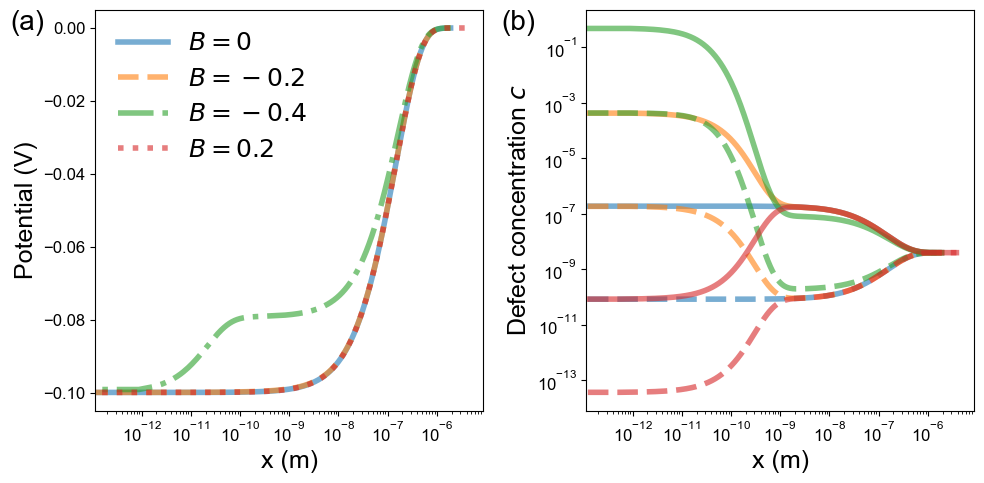

In [462]:
fnames = ['paper-case', 'paper-case-fnB0p2',  'paper-case-fnB0p4', 'paper-case-V0.1-fnB-0.2-int0' ] #'paper-case-fnB0p1',  'paper-case-fnB0p3',
legends = [ r'$B=0$', r'$B=-0.2$',  r'$B=-0.4$', r'$B=0.2$' ]
linestyles = ['-', '--', '-.', ':']
dir = '/Users/zeeshan/projects/edl_solid/test/tests/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, _ = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', linestyles = linestyles, subplotlabel = ['a', 'b'])

fig.savefig(figdir+'/Beffect.pdf', bbox_inches='tight', transparent=True, dpi=1200)

---------Case----------- paper-case-V0.5-fnB0.2-int0.01_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-V0.5-fnB0.2-int0.2_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-V0.5-fnB0.2-int0.5_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-V0.5-fnB0.2-int1.0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09


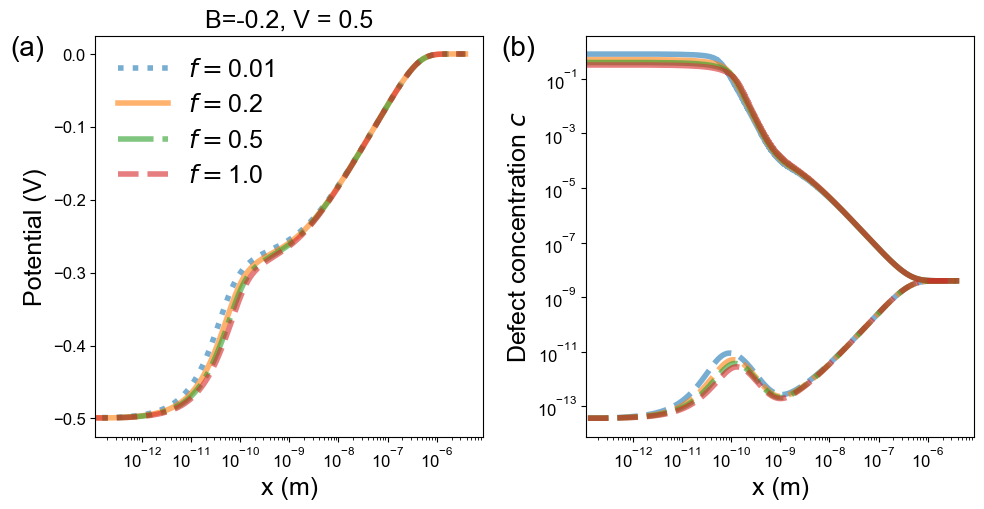

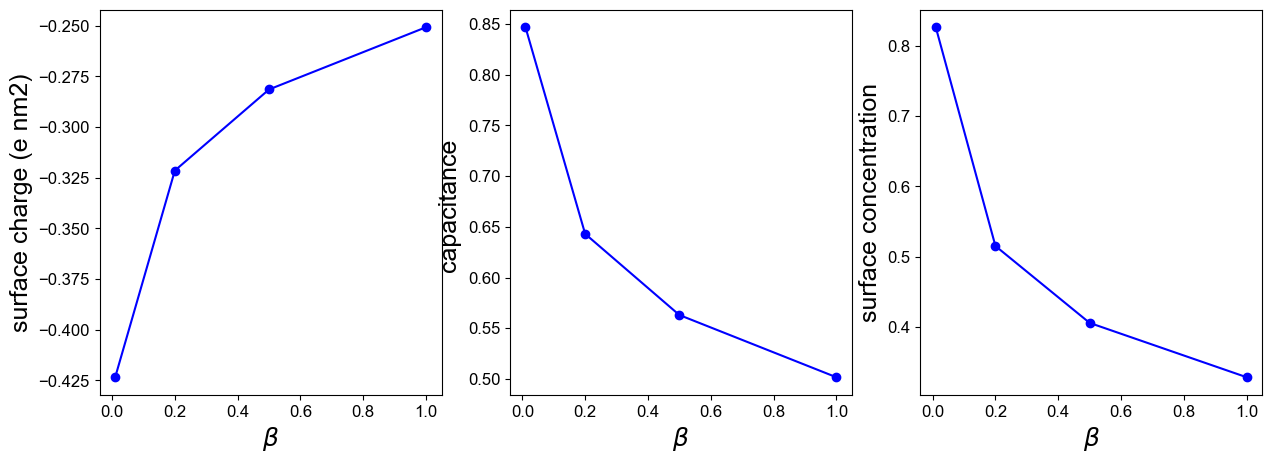

In [452]:
fnames = [ 'paper-case-V0.5-fnB0.2-int0.01', 'paper-case-V0.5-fnB0.2-int0.2', 'paper-case-V0.5-fnB0.2-int0.5', 'paper-case-V0.5-fnB0.2-int1.0']

ints = [0.01, 0.2, 0.5, 1.0]
legends = [r'$f = $'+str(item) for item in ints]
# legends = ['int0.01', 'int-0.5',  'int1.0']
linestyles = [':','solid', 'dashdot', 'dashed']
dir = '/Users/zeeshan/projects/edl_solid/test/tests/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, stats = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', linestyles=linestyles, subplotlabel = ['a', 'b', 'c'])
ax[0].set_title('B=-0.2, V = 0.5')

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(ints, stats['surf_charges'], '-bo')
ax[0].set_ylabel('surface charge (e nm2)')
ax[1].plot(ints, stats['capcs'], '-bo')
ax[1].set_ylabel('capacitance ')
ax[2].plot(ints, stats['surf_concs'], '-bo')
ax[2].set_ylabel('surface concentration')
for axin in ax:
    axin.set_xlabel(r'$\beta$')

---------Case----------- paper-case-V1.0-fnB0.2-int0.01_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-V1.0-fnB0.2-int0.2_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-V1.0-fnB0.2-int0.5_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-V1.0-fnB0.2-int1.0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-V1.0-fnB0.2-int2.0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09


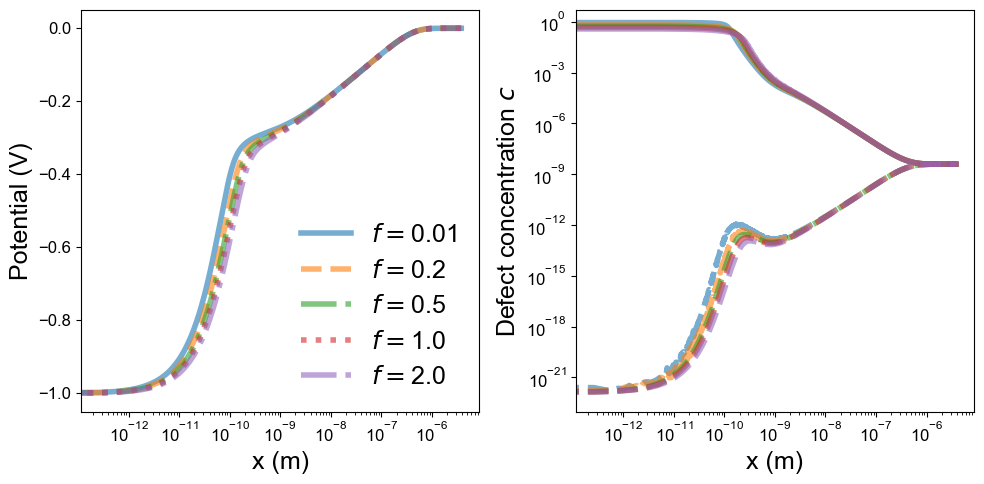

In [457]:
# fnames = ['paper-case-V1.0-fnB0-int0.01', 'paper-case-V1.0-fnB0-int0.2', 'paper-case-V1.0-fnB0-int0.5', 'paper-case-V1.0-fnB0-int1.0', 'paper-case-V1.0-fnB0-int2.0']
ints = [0.01, 0.2, 0.5, 1.0, 2.0]
fnames= ['paper-case-V1.0-fnB0.2-int' + str(item) for item in ints]

legends = [r'$f = $'+str(item) for item in ints]

linestyles = ['-', '--', '-.', ':', 'dashdot']
dir = '/Users/zeeshan/projects/edl_solid/test/tests/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, stats = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', linestyles=linestyles, subplotlabel = None)
#ax[0].set_title('B=0, V=1')
ax[1].set_ylim(top = 5)

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# # ax[0].plot(ints, stats['surf_charges'], '-bo')
# # ax[0].set_ylabel('surface charge (e nm2)')
# # ax[1].plot(ints, stats['capcs'], '-bo')
# # ax[1].set_ylabel('capacitance ')
# ax.plot(ints, stats['surf_concs'], '-bo')
# ax.set_ylabel('surface concentration')
# ax.set_xlabel(r'$f$ (eV)')

fig.savefig(figdir+'/fint_effect.pdf', bbox_inches='tight', transparent=True, dpi=1200)


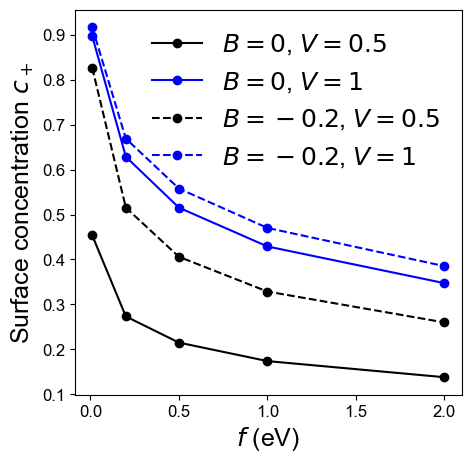

In [448]:
#get surface concs for plot
ints = [0.01, 0.2, 0.5, 1.0, 2.0]
files_B0_V0p5 = ['paper-case-V0.5-fnB0-int0.01', 'paper-case-V0.5-fnB0-int0.2', 'paper-case-V0.5-fnB0-int0.5', 'paper-case-V0.5-fnB0-int1.0', 'paper-case-V0.5-fnB0-int2.0']
files_B0p2_V0p5 = ['paper-case-V0.5-fnB0.2-int0.01', 'paper-case-V0.5-fnB0.2-int0.2', 'paper-case-V0.5-fnB0.2-int0.5', 'paper-case-V0.5-fnB0.2-int1.0', 'paper-case-V0.5-fnB0.2-int2.0']
files_B0_V1 = ['paper-case-V1.0-fnB0-int0.01', 'paper-case-V1.0-fnB0-int0.2', 'paper-case-V1.0-fnB0-int0.5', 'paper-case-V1.0-fnB0-int1.0', 'paper-case-V1.0-fnB0-int2.0']
files_B0p2_V1 = ['paper-case-V1.0-fnB0.2-int0.01', 'paper-case-V1.0-fnB0.2-int0.2', 'paper-case-V1.0-fnB0.2-int0.5', 'paper-case-V1.0-fnB0.2-int1.0', 'paper-case-V1.0-fnB0.2-int2.0']
dir = '/Users/zeeshan/projects/edl_solid/test/tests/'

files_B0_V0p5 = [dir + item + '_out.e' for item in files_B0_V0p5]
files_B0_V1 = [dir + item + '_out.e' for item in fnames]
files_B0p2_V0p5 = [dir + item + '_out.e' for item in files_B0p2_V0p5]
files_B0p2_V1 = [dir + item + '_out.e' for item in files_B0p2_V1]

stats_B0p2_V0p5 = stats_nmesh(files_B0p2_V0p5)
stats_B0_V0p5 = stats_nmesh(files_B0_V0p5)
stats_B0_V1 = stats_nmesh(files_B0_V1)
stats_B0p2_V1 = stats_nmesh(files_B0p2_V1)

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(ints, stats_B0_V0p5['surf_concs'], '-ko', label = r'$B=0$, $V=0.5$')
ax.plot(ints, stats_B0_V1['surf_concs'], '-bo', label = r'$B=0$, $V=1$')
ax.plot(ints, stats_B0p2_V0p5['surf_concs'], '--ko', label = r'$B=-0.2$, $V=0.5$')
ax.plot(ints, stats_B0p2_V1['surf_concs'], '--bo', label = r'$B=-0.2$, $V=1$')
ax.legend(frameon = False)

ax.set_ylabel(r'Surface concentration $c_+$')
ax.set_xlabel(r'$f$ (eV)')

fig.savefig(figdir+'/surf_concs.pdf', bbox_inches='tight', transparent=True, dpi=1200)

nsteps =  1
nsteps =  1
nsteps =  1
nsteps =  1
surface concs =  0.5151474042037588 1.512971032068454e-17
---------Case----------- paper-case-V0.5-fnB0-int0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
surface concs =  1.0298620186507164 3.518675873384645e-14
---------Case----------- paper-case-V0.5-fnB0.2-int0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
surface concs =  1.0302945985999357 8.183669477958542e-11
---------Case----------- paper-case-V0.5-fnB0.4-int0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
surface concs =  0.0004401597201087757 6.504792350586555e-21
---------Case----------- paper-case-V0.5-fnB-0.2-int0_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
surface charges (C/m2) =  [-0.15877392 -0.48277743 -0.65764889 -0.0239043 ]
surface charges (e/nm2) =  [-0.99109814 -3.01359193 -4.10517411 -0.1492153

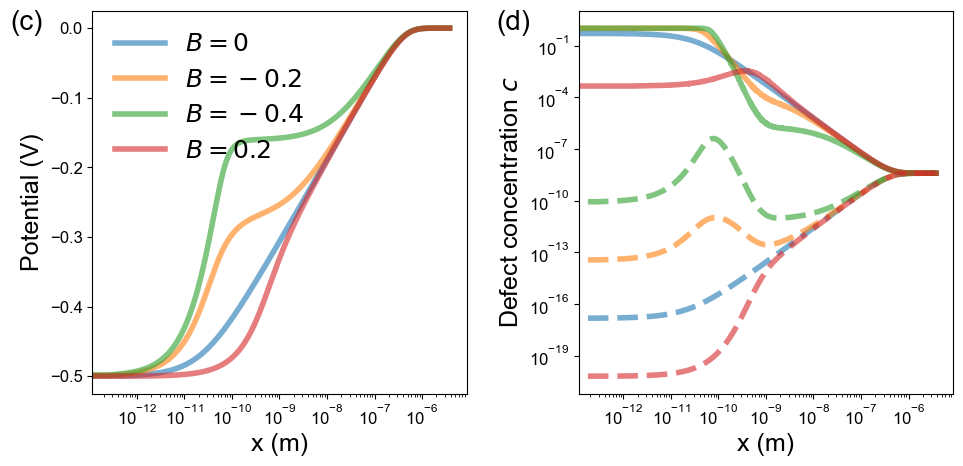

In [856]:
fnames = ['paper-case-V0.5-fnB0-int0', 'paper-case-V0.5-fnB0.2-int0' , 'paper-case-V0.5-fnB0.4-int0', 'paper-case-V0.5-fnB-0.2-int0'] #  r'B=0',
# legends = [r'B=0', r'B=-0.4', r'B=-0.2', r'B =0.2']
legends = [r'$B=0$', r'$B=-0.2$',  r'$B=-0.4$', r'$B=0.2$']
dir = '/Users/zeeshan/projects/edl_solid/test/tests/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, stats = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', subplotlabel=['c', 'd'])

fig.savefig(figdir + '/Beffect-V0.5.pdf', dpi=600, bbox_inches='tight', transparent=True)


Material will break down at 1 occupancy, need to change the interaction model

---------Case----------- paper-case-fnB0-int0.01-V-0.01_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.01-V-0.02_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.01-V-0.03_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.01-V-0.04_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.01-V-0.05_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.01-V-0.06_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.01-V-0.07_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cn

/var/folders/ck/_5l7w6ps1n3194_9fnm_swnw0000gn/T/ipykernel_99813/2276946344.py:116: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


---------Case----------- paper-case-fnB0.2-int0.01-V-0.01_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.01-V-0.02_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.01-V-0.03_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.01-V-0.04_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.01-V-0.05_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.01-V-0.06_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.01-V-0.07_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos =

/Users/zeeshan/miniconda3_arm64/envs/py39/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


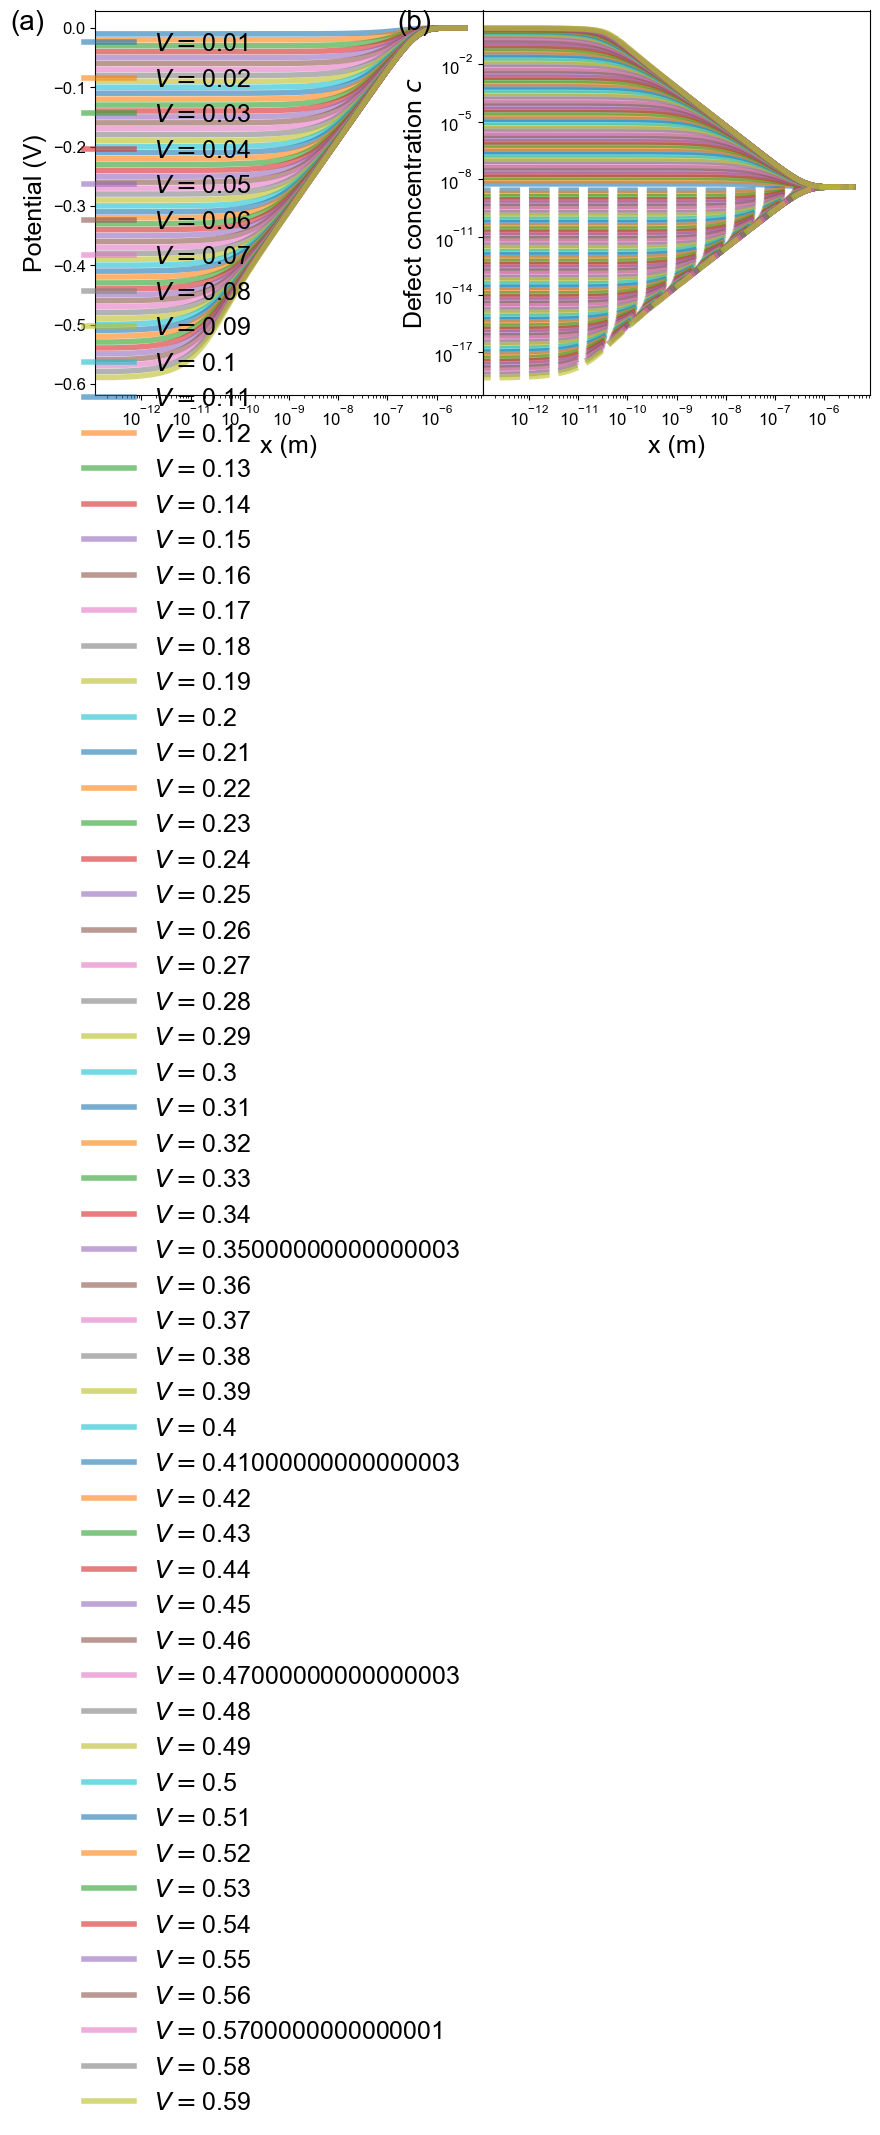

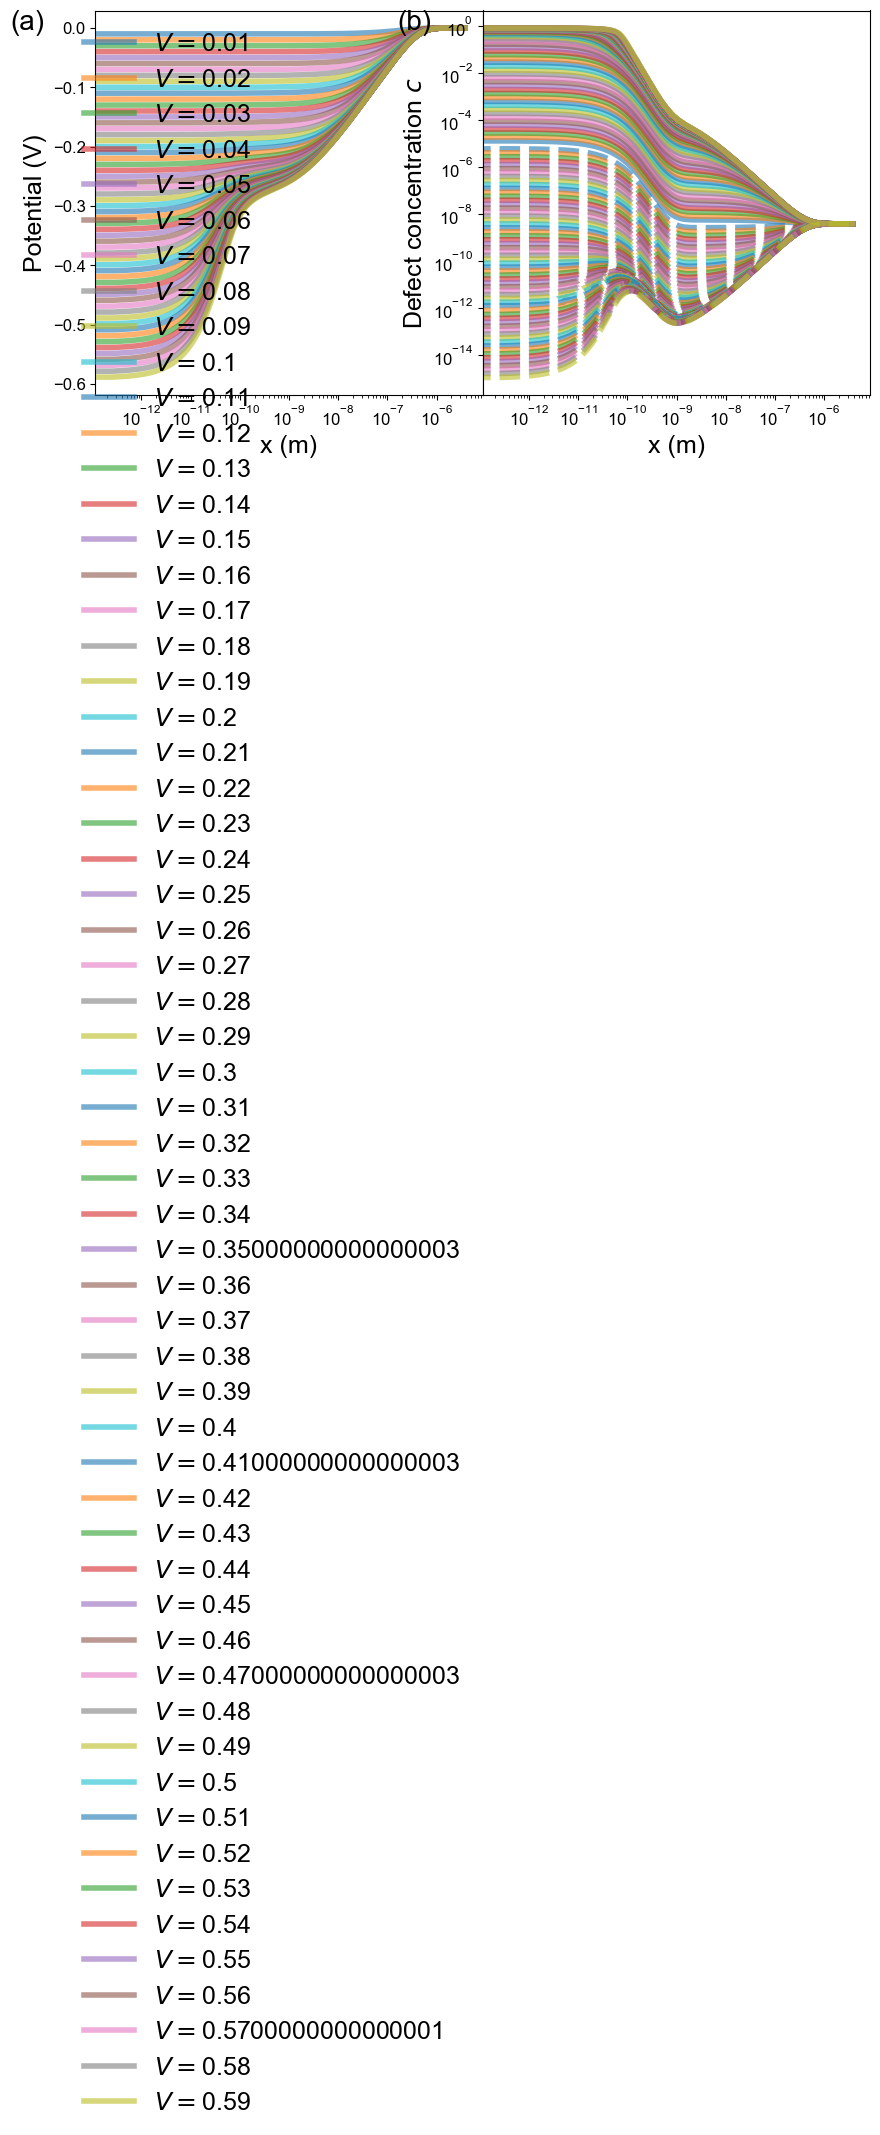

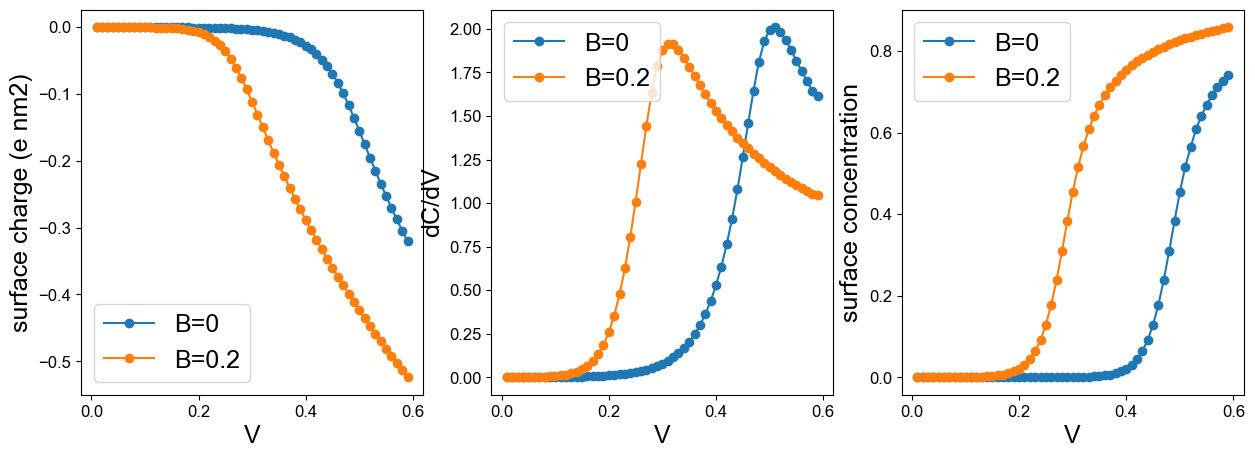

In [479]:
#This is for int 0.01 - capacitance
Vs = np.arange(0.01, 0.6, 0.01)

fnames = ['paper-case-fnB0-int0.01-V-{:.2f}'.format(item) for item in Vs]
legends = [r'$V = $'+str(item) for item in Vs]

linestyles = ['-']*len(Vs)  #['-', '--', '-.', ':', '-.']
# linestyles = markers_array[:len(fnames)]
dir = '/Users/zeeshan/Library/CloudStorage/OneDrive-TexasTechUniversity/TTU/Research/electrical-double-layer/capacitance/int0.01/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, stats = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', linestyles=linestyles, subplotlabel = ['a', 'b'])

#The B case

fnames = ['paper-case-fnB0.2-int0.01-V-{:.2f}'.format(item) for item in Vs]
legends = [r'$V = $'+str(item) for item in Vs]

linestyles = ['-']*len(Vs)  #['-', '--', '-.', ':', '-.']
# linestyles = markers_array[:len(fnames)]
dir = '/Users/zeeshan/Library/CloudStorage/OneDrive-TexasTechUniversity/TTU/Research/electrical-double-layer/capacitance/int0.01/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, statsB = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', linestyles=linestyles, subplotlabel = ['a', 'b'])

#-------------------------------- B effect

print('surface charges = ', stats['surf_charges'])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(Vs, stats['surf_charges'], '-o', label = 'B=0')
ax[0].plot(Vs, statsB['surf_charges'], '-o', label = 'B=0.2')   
ax[0].set_ylabel('surface charge (e nm2)')

diffCs = np.gradient(np.abs(stats['surf_charges']), Vs)
diffCsB = np.gradient(np.abs(statsB['surf_charges']), Vs)
ax[1].plot(Vs, diffCs, '-o', label = 'B=0')
ax[1].plot(Vs, diffCsB, '-o', label = 'B=0.2')  
ax[1].set_ylabel('dC/dV')

ax[2].plot(Vs, stats['surf_concs'], '-o', label = 'B=0')
ax[2].plot(Vs, statsB['surf_concs'], '-o', label = 'B=0.2')
ax[2].set_ylabel('surface concentration')
for axin in ax:
    axin.set_xlabel('V')
    axin.legend()

---------Case----------- paper-case-fnB0-int0.5-V-0.01_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.5-V-0.02_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.5-V-0.03_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.5-V-0.04_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.5-V-0.05_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.5-V-0.06_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0-int0.5-V-0.07_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.

/var/folders/ck/_5l7w6ps1n3194_9fnm_swnw0000gn/T/ipykernel_99813/2276946344.py:116: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(59,)
---------Case----------- paper-case-fnB0.2-int0.5-V-0.01_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.5-V-0.02_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.5-V-0.03_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.5-V-0.04_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.5-V-0.05_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.5-V-0.06_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.2-int0.5-V-0.07_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 

/var/folders/ck/_5l7w6ps1n3194_9fnm_swnw0000gn/T/ipykernel_99813/2276946344.py:116: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


surface charges =  [-4.62306858e-06 -9.42031339e-06 -1.45724727e-05 -2.02736565e-05
 -2.67386590e-05 -3.42110517e-05 -4.29723595e-05 -5.33526669e-05
 -6.57430544e-05 -8.06103316e-05 -9.85146240e-05 -1.20130475e-04
 -1.46272257e-04 -1.77924854e-04 -2.16280621e-04 -2.62784756e-04
 -3.19189143e-04 -3.87618677e-04 -4.70651212e-04 -5.71414613e-04
 -6.93707812e-04 -8.42131856e-04 -1.02227872e-03 -1.24093781e-03
 -1.50633937e-03 -1.82847792e-03 -2.21948224e-03 -2.69406713e-03
 -3.27008660e-03 -3.96919867e-03 -4.81766636e-03 -5.84732396e-03
 -7.09673208e-03 -8.61255231e-03 -1.04511537e-02 -1.26804555e-02
 -1.53819226e-02 -1.86525086e-02 -2.26059451e-02 -2.73720054e-02
 -3.30906972e-02 -3.98956373e-02 -4.78792921e-02 -5.70411759e-02
 -6.72478909e-02 -7.82517868e-02 -8.97675803e-02 -1.01545844e-01
 -1.13402885e-01 -1.25216246e-01 -1.36892586e-01 -1.48451039e-01
 -1.59791253e-01 -1.70934613e-01 -1.81900003e-01 -1.92664098e-01
 -2.03209667e-01 -2.13587785e-01 -2.23763078e-01]


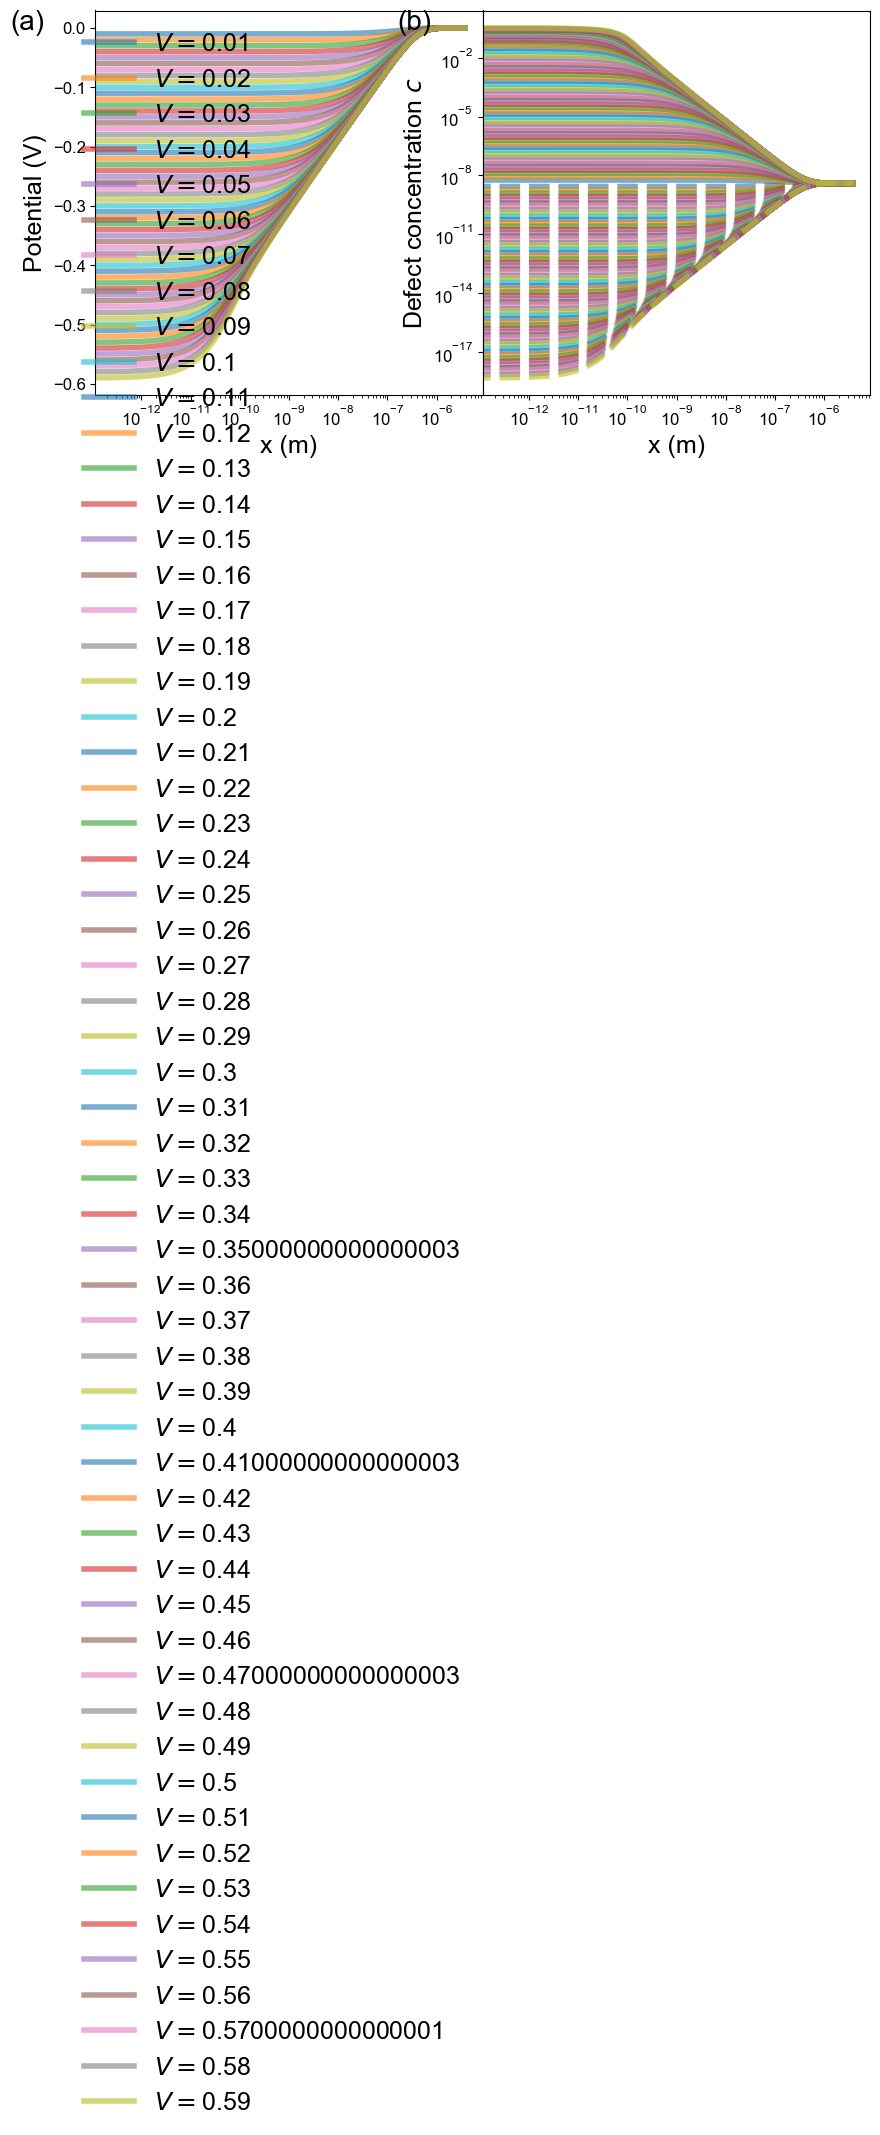

/Users/zeeshan/miniconda3_arm64/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


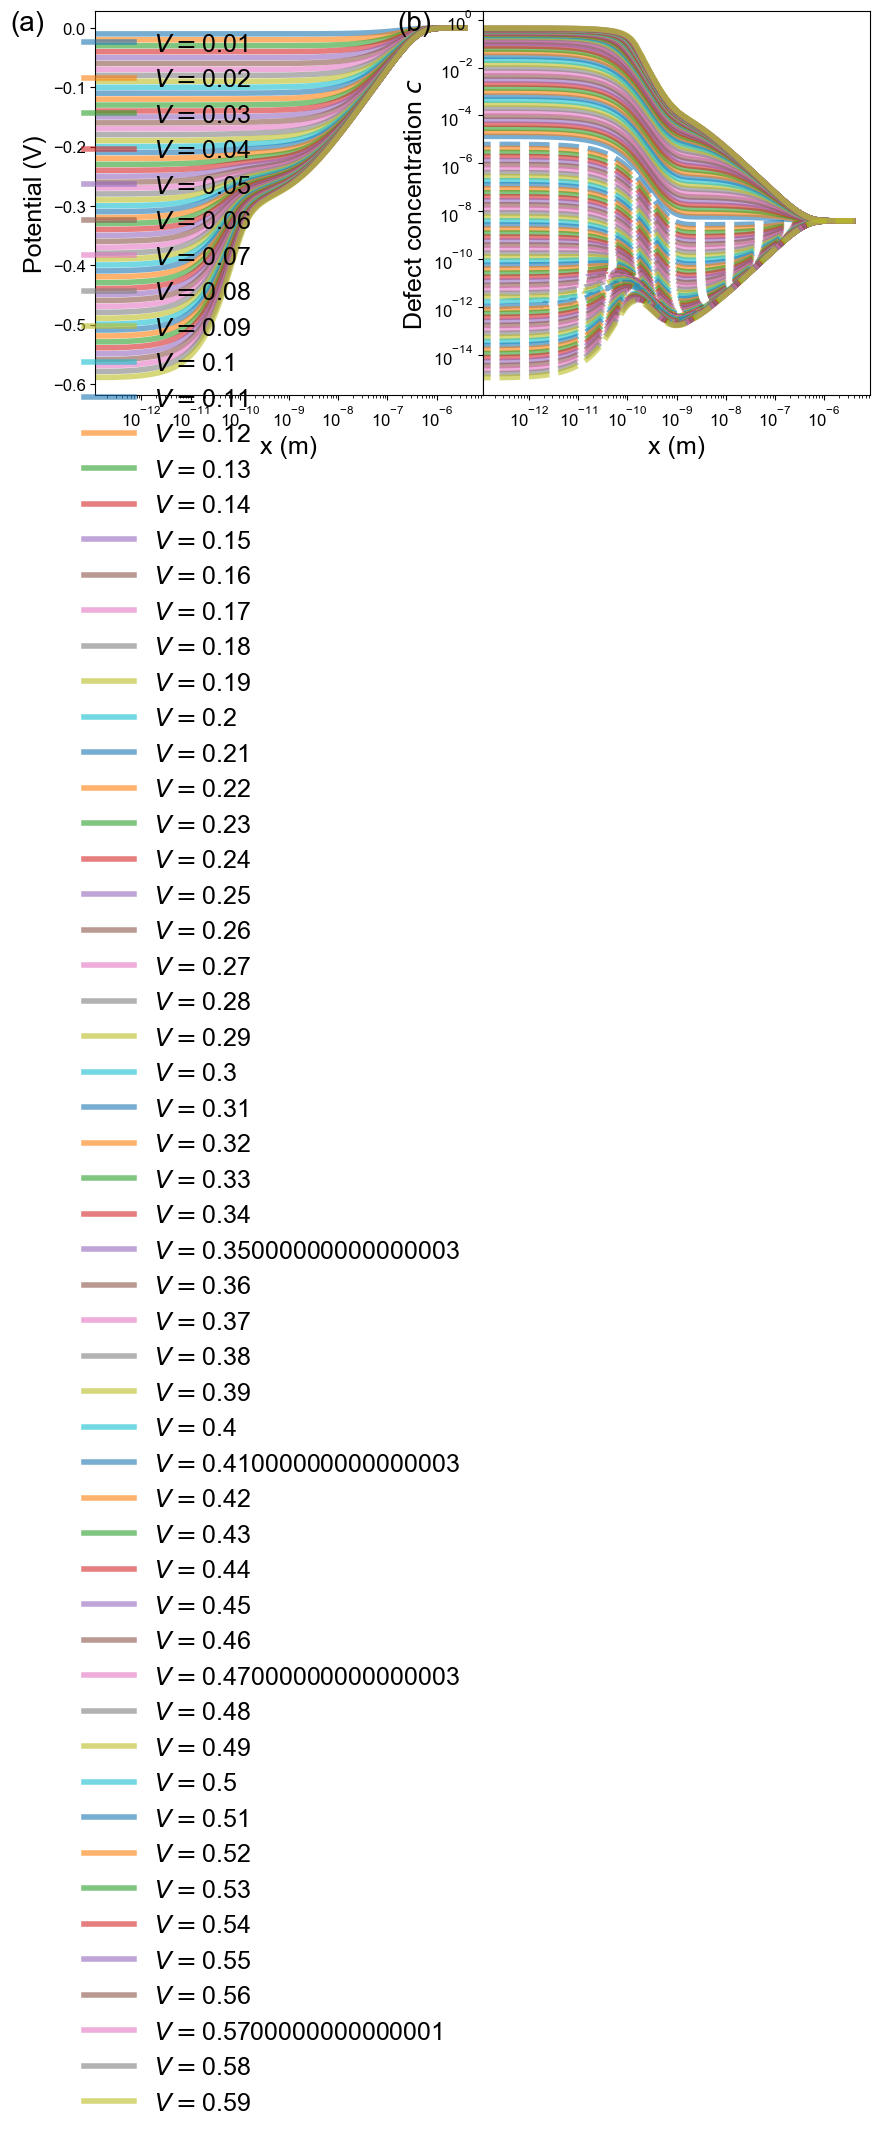

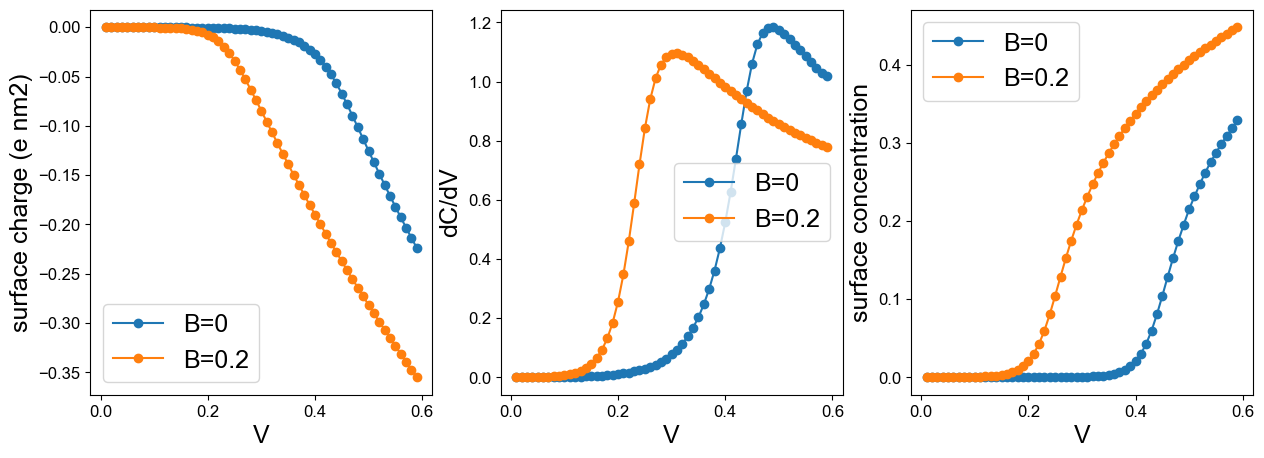

In [478]:
#This is for int0.5
VsB0 = np.arange(0.01, 0.6, 0.01)

fnames = ['paper-case-fnB0-int0.5-V-{:.2f}'.format(item) for item in VsB0]
legends = [r'$V = $'+str(item) for item in VsB0]

linestyles = ['-']*len(VsB0)  #['-', '--', '-.', ':', '-.']
# linestyles = markers_array[:len(fnames)]
dir = '/Users/zeeshan/Library/CloudStorage/OneDrive-TexasTechUniversity/TTU/Research/electrical-double-layer/capacitance/int0.5/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, stats = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', linestyles=linestyles, subplotlabel = ['a', 'b'])

print(stats['surf_charges'].shape)

#The B case
Vs = np.arange(0.01, 0.6, 0.01)
fnames = ['paper-case-fnB0.2-int0.5-V-{:.2f}'.format(item) for item in Vs]
legends = [r'$V = $'+str(item) for item in Vs]

linestyles = ['-']*len(Vs)  #['-', '--', '-.', ':', '-.']
# linestyles = markers_array[:len(fnames)]
# dir = '/Users/zeeshan/projects/edl_solid/test/tests/capacitance/int0.01/'
files = [dir + item + '_out.e' for item in fnames]
fig, ax, statsB = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', linestyles=linestyles, subplotlabel = ['a', 'b'])


stats_int = stats
statsB_int = statsB
#-------------------------------- B effect

print('surface charges = ', stats['surf_charges'])



fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(VsB0, stats['surf_charges'], '-o', label = 'B=0')
ax[0].plot(Vs, statsB['surf_charges'], '-o', label = 'B=0.2')   
ax[0].set_ylabel('surface charge (e nm2)')

# ax[1].plot(Vs, stats['capcs'], '-o')
# ax[1].plot(Vs, statsB['capcs'], '-o')
# ax[1].set_ylabel('capacitance ')

diffCs = np.gradient(np.abs(stats['surf_charges']), VsB0)
diffCsB = np.gradient(np.abs(statsB['surf_charges']), Vs)
ax[1].plot(VsB0, diffCs, '-o', label = 'B=0')
ax[1].plot(Vs, diffCsB, '-o', label = 'B=0.2')  
ax[1].set_ylabel('dC/dV')

ax[2].plot(VsB0, stats['surf_concs'], '-o', label = 'B=0')
ax[2].plot(Vs, statsB['surf_concs'], '-o', label = 'B=0.2')
ax[2].set_ylabel('surface concentration')
for axin in ax:
    axin.set_xlabel('V')
    axin.legend()

[0.1, 0.2, 0.3, 0.4, 0.5]
nsteps =  1
nsteps =  1
nsteps =  1
nsteps =  1
nsteps =  1
---------Case----------- paper-case-fnB0.4-int0.5-V-0.10_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.4-int0.5-V-0.20_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.4-int0.5-V-0.30_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.4-int0.5-V-0.40_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09
---------Case----------- paper-case-fnB0.4-int0.5-V-0.50_out.e
length =  3.8e-06
Bulk values: phi = -0.0000 V, cpos = 3.948e-09, cneg = 3.948e-09


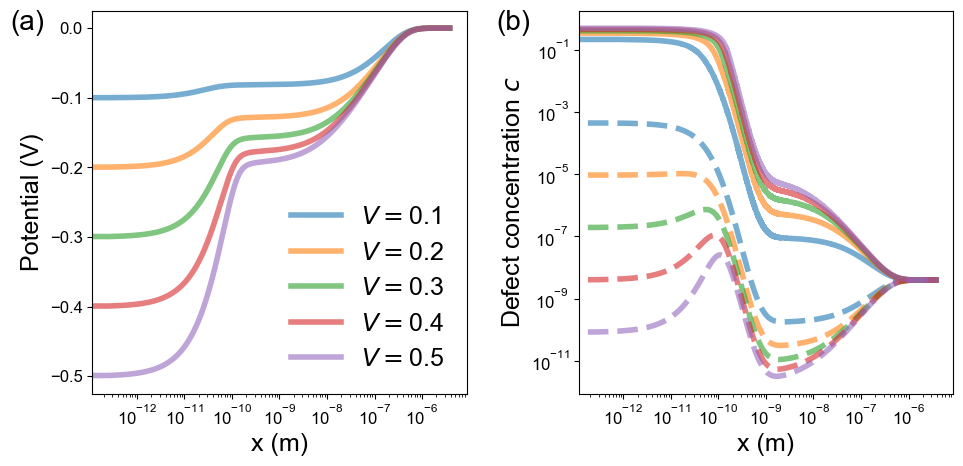

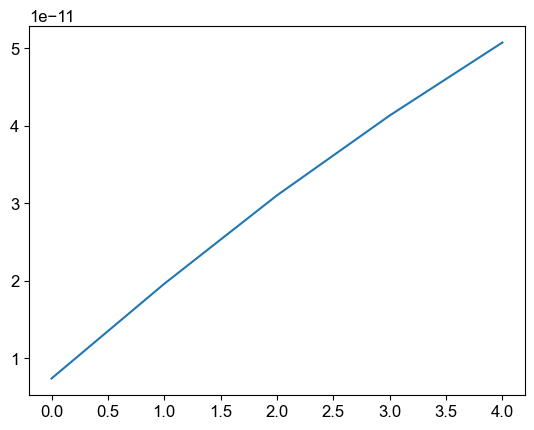

In [177]:

linestyles = ['-']*len(Vs)  #['-', '--', '-.', ':', '-.']
# linestyles = markers_array[:len(fnames)]
dir = '/Users/zeeshan/Library/CloudStorage/OneDrive-TexasTechUniversity/TTU/Research/electrical-double-layer/capacitance/int0.5/'
files = glob(dir+'paper-case-fnB0.4-int0.5-V-*_out.e')
files.sort()

Vs = []
for file in files:
    # Split the filename by the 'V-' and '_out.e' parts
    parts = file.split('V-')  # This splits on 'V-'
    if len(parts) > 1:
        potential_with_suffix = parts[1].split('_out.e')[0]  # Get the part before '_out.e'
        # print(f"File: {file}, Potential: {potential_with_suffix}")
    else:
        print(f"File: {file} does not match the expected pattern.")
    Vs.append(float(potential_with_suffix))

legends = [r'$V = $'+str(item) for item in Vs]

print(Vs)
fig, ax, stats = compare_nmesh(files, legends, xscale = 'log', yscale = 'log', subplotlabel = ['a', 'b'])

#print(files)

fig, ax = plt.subplots()
ax.plot(stats['integrals_conc_pos'])


In [503]:
# 0.01 int
dir = '/Users/zeeshan/Library/CloudStorage/OneDrive-TexasTechUniversity/TTU/Research/electrical-double-layer/capacitance/int0.01/'
files = glob(dir+'paper-case-fnB*-int0.01-V-*_out.e')
files.sort()

Bvals = []
Vvals = []
# Loop through the files and extract the values of B and V
for file in files:
    # Extract the part of the filename after 'fnB' and before '-int0.5'
    b_value = file.split('fnB')[1].split('-int0.01')[0]
    
    # Extract the part of the filename after 'V-' and before '_out.e'
    v_value = file.split('V-')[1].split('_out.e')[0]

    Bvals.append(-float(b_value))
    Vvals.append(float(v_value))

stats = stats_nmesh(files)
Bvals = np.array(Bvals)
Vvals = np.array(Vvals)
#-------------------------------- int effect
#0.5 int
dir = '/Users/zeeshan/Library/CloudStorage/OneDrive-TexasTechUniversity/TTU/Research/electrical-double-layer/capacitance/int0.5/'
files = glob(dir+'paper-case-fnB*-int0.5-V-*_out.e')
files.sort()

Bvals_int = []
Vvals_int = []
# Loop through the files and extract the values of B and V
for file in files:
    # Extract the part of the filename after 'fnB' and before '-int0.5'
    b_value = file.split('fnB')[1].split('-int0.5')[0]
    
    # Extract the part of the filename after 'V-' and before '_out.e'
    v_value = file.split('V-')[1].split('_out.e')[0]

    Bvals_int.append(-float(b_value))
    Vvals_int.append(float(v_value))

stats_int = stats_nmesh(files)
Bvals_int = np.array(Bvals_int)
Vvals_int = np.array(Vvals_int)


153
153
4909.738461476228


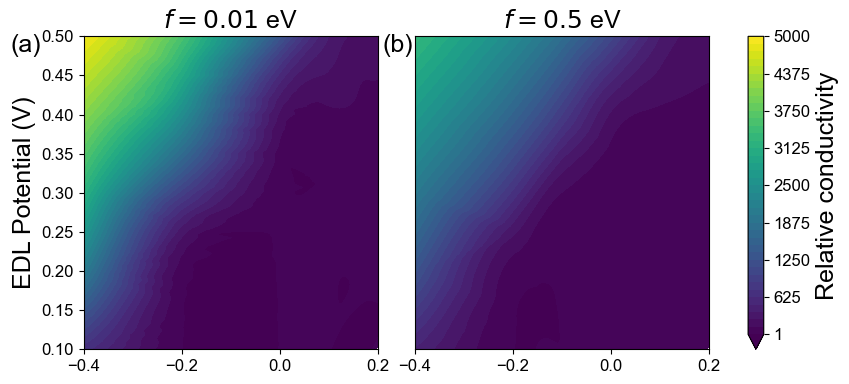

In [535]:
mask = (Vvals >= 0.0) & (Vvals <= 0.5) & (Bvals >= -0.4) & (Bvals <= 0.2)
x = Bvals[mask]
y = Vvals[mask]
integrals_conc_pos = np.array(stats['integrals_conc_pos'])[mask]
z = integrals_conc_pos

mask = (Vvals_int >= 0.0) & (Vvals_int <= 0.501)
print(len(mask))
print(len(stats_int['integrals_conc_pos']))

xint = Bvals_int[mask]
yint = Vvals_int[mask]
integrals_conc_pos_int = np.array(stats_int['integrals_conc_pos'])[mask]
zint = integrals_conc_pos_int

#Normalize the conductivity
zref = min(np.min(z), np.min(zint))
z = z/zref
zint = zint/zref

grid_x, grid_y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                             np.linspace(y.min(), y.max(), 100))

# Interpolate z values on the grid
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
grid_zint = griddata((xint, yint), zint, (grid_x, grid_y), method='cubic')
print(max(z))
levels = np.arange(0, round(max(z)/500) * 500  + 1, 125)
levels[0] = 1

fig, ax = plt.subplots(1,2, figsize=(9,4))

# fig.colorbar(CS)  # Add a color bar to the plot
cmap = plt.get_cmap('viridis')

contour1 = ax[0].contourf(grid_x, grid_y, grid_z, levels = levels, cmap=cmap, extend = 'min')  # 20 contour levels

# Plot the contour lines on top
# contour = ax[0].contour(grid_x, grid_y, grid_z, levels=levels, colors='black')

# Add labels to the contour lines
# ax[0].clabel(contour, fmt='%2.1f', colors='white', fontsize=10)

# fig.colorbar(contour1, ax=ax[0])

# levels2 = np.linspace(1, max(max(z), max(zint)), 50)
contour2 = ax[1].contourf(grid_x, grid_y, grid_zint, levels = levels, cmap = cmap, extend= 'min')  # 20 contour levels

ax[0].set_title(r'$f = 0.01$ eV')
ax[1].set_title(r'$f = 0.5$ eV')

ax[0].set_xlabel("B (eV)")
ax[1].set_xlabel("B (eV)")
ax[0].set_ylabel("EDL Potential (V)")
#plt.ylabel("EDL Potential (V)")
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[0].set_xlim([-0.4, 0.2])
ax[0].set_ylim([0.1,0.5])

ax[1].set_xlim([-0.4, 0.2])
ax[1].set_ylim([0.1,0.5])

plt.tight_layout()


cbar = fig.colorbar(contour2, ax=ax)
cbar.set_label('Relative conductivity')

ax[0].text(-0.25, 0.95, '(a)', transform=ax[0].transAxes, fontsize = 18)
ax[1].text(-0.11, 0.95, '(b)', transform=ax[1].transAxes, fontsize = 18)

# for n, axin in enumerate(ax):
#     axin.text(-0.25, 0.95, '('+string.ascii_lowercase[n]+')', transform=axin.transAxes, size=20)

fig.savefig(figdir + '/BV-contour.pdf', dpi=1200, bbox_inches='tight', transparent=True)

153
153
0.743996545791467


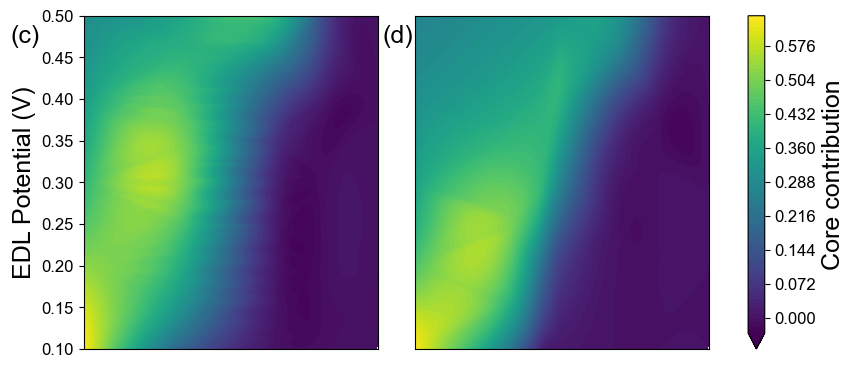

In [534]:
mask = (Vvals >= 0.0) & (Vvals <= 0.5) & (Bvals >= -0.4) & (Bvals <= 0.2)
x = Bvals[mask]
y = Vvals[mask]
integrals_conc_pos = np.array(stats['integrals_conc_pos_core'])[mask] / np.array(stats['integrals_conc_pos'])[mask]
z = integrals_conc_pos

mask = (Vvals_int >= 0.0) & (Vvals_int <= 0.501)
print(len(mask))
print(len(stats_int['integrals_conc_pos']))

xint = Bvals_int[mask]
yint = Vvals_int[mask]
integrals_conc_pos_int = np.array(stats_int['integrals_conc_pos_core'])[mask] / np.array(stats_int['integrals_conc_pos'])[mask]
zint = integrals_conc_pos_int

#Normalize the conductivity
zref = 1
z = z/zref
zint = zint/zref

grid_x, grid_y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                             np.linspace(y.min(), y.max(), 100))

# Interpolate z values on the grid
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
grid_zint = griddata((xint, yint), zint, (grid_x, grid_y), method='cubic')
print(max(z))
# levels = np.arange(0, round(max(z)/500) * 500  + 1, 125)
# levels[0] = 1
levels = 100
fig, ax = plt.subplots(1,2, figsize=(9,4))

# fig.colorbar(CS)  # Add a color bar to the plot
cmap = plt.get_cmap('viridis')

contour1 = ax[0].contourf(grid_x, grid_y, grid_z, levels = levels, cmap=cmap, extend = 'min')  # 20 contour levels

# Plot the contour lines on top
# contour = ax[0].contour(grid_x, grid_y, grid_z, levels=levels, colors='black')

# Add labels to the contour lines
# ax[0].clabel(contour, fmt='%2.1f', colors='white', fontsize=10)

# fig.colorbar(contour1, ax=ax[0])

# levels2 = np.linspace(1, max(max(z), max(zint)), 50)
contour2 = ax[1].contourf(grid_x, grid_y, grid_zint, levels = levels, cmap = cmap, extend= 'min')  # 20 contour levels

# ax[0].set_title(r'$f = 0.01$ eV')
# ax[1].set_title(r'$f = 0.5$ eV')

# ax[0].set_xlabel("B (eV)")
# ax[1].set_xlabel("B (eV)")
ax[0].set_ylabel("EDL Potential (V)")
#plt.ylabel("EDL Potential (V)")
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[0].set_xlim([-0.4, 0.2])
ax[0].set_ylim([0.1,0.5])

ax[1].set_xlim([-0.4, 0.2])
ax[1].set_ylim([0.1,0.5])

plt.tight_layout()

ax[0].set_xticklabels([])
ax[0].set_xticks([])
ax[1].set_xticklabels([])
ax[1].set_xticks([])

cbar = fig.colorbar(contour2, ax=ax)
cbar.set_label('Core contribution')

ax[0].text(-0.25, 0.92, '(c)', transform=ax[0].transAxes, fontsize = 18)
ax[1].text(-0.11, 0.92, '(d)', transform=ax[1].transAxes, fontsize = 18)

# for n, axin in enumerate(ax):
#     axin.text(-0.25, 0.95, '('+string.ascii_lowercase[n]+')', transform=axin.transAxes, size=20)

fig.savefig(figdir + '/BV-contour-core.pdf', dpi=1200, bbox_inches='tight', transparent=True)

0.31
0.31
0.51
0.49


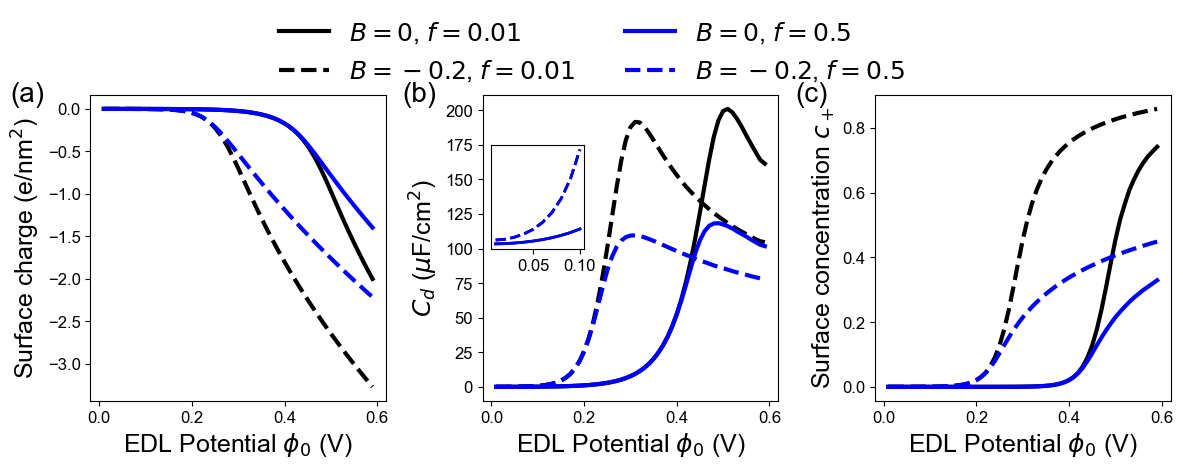

In [476]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

line1, = ax[0].plot(Vs, stats['surf_charges']/1.602e-19 * 1e-18, '-k', label = r'$B=0$, $f=0.01$', markersize=4, linewidth=3)
line2, = ax[0].plot(Vs, statsB['surf_charges']/1.602e-19 * 1e-18, '--k', label = r'$B=-0.2$, $f=0.01$', markersize=4, linewidth=3)   
line3, = ax[0].plot(Vs, stats_int['surf_charges']/1.602e-19 * 1e-18, '-b', label = r'$B=0$, $f=0.5$', markersize=5, linewidth=3)
line4, = ax[0].plot(Vs, statsB_int['surf_charges']/1.602e-19 * 1e-18, '--b', label = r'$B=-0.2$, $f=0.5$', markersize=5, linewidth=3)
ax[0].set_ylabel(r'Surface charge (e/nm$^2$)')

#convert to muF/cm2
diffCs = np.gradient(np.abs(stats['surf_charges']), Vs) * 1e6 * 1e-4
diffCsB = np.gradient(np.abs(statsB['surf_charges']), Vs) * 1e6 * 1e-4
diffCs_int = np.gradient(np.abs(stats_int['surf_charges']), Vs) * 1e6 * 1e-4
diffCsB_int = np.gradient(np.abs(statsB_int['surf_charges']), Vs) * 1e6 * 1e-4
ax[1].plot(Vs, diffCs, '-k', label = 'B=0, f=0.01', markersize=4, linewidth=3)
ax[1].plot(Vs, diffCsB, '--k', label = 'B=-0.2, f=0.01', markersize=4, linewidth=3)
ax[1].plot(Vs, diffCs_int, '-b', label = 'B=0, f=0.5', markersize=4, linewidth=3)
ax[1].plot(Vs, diffCsB_int, '--b', label = 'B=-0.2, f=0.5', markersize=4, linewidth=3)  
ax[1].set_ylabel(r'$C_d$ ($\mu$F/cm$^2$)')

ax[2].plot(Vs, stats['surf_concs'], '-k', label = 'B=0, f=0.01', markersize=4, linewidth=3)
ax[2].plot(Vs, statsB['surf_concs'], '--k', label = 'B=-0.2, f=0.01', markersize=4, linewidth=3)
ax[2].plot(Vs, stats_int['surf_concs'], '-b', label = 'B=0, f=0.5', markersize=4, linewidth=3)
ax[2].plot(Vs, statsB_int['surf_concs'], '--b', label = 'B=-0.2, f=0.5', markersize=4, linewidth=3)
ax[2].set_ylabel(r'Surface concentration $c_+$')

for axin in ax:
    axin.set_xlabel(r'EDL Potential $\phi_0$ (V)')
    # axin.legend(frameon = False)

# Combine all legend handles and labels
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]

# Place the legend outside the figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, +1.2), ncol=2, frameon = False)

# axin1 = ax[1].inset_axes([0.8, 0.1, 0.15, 0.15])
axin = ax[1].inset_axes([0.0, 1.0 * 1e6 * 1e-4 , 0.2, 0.75 * 1e6 * 1e-4], transform=ax[1].transData)
axin.plot(Vs[:10], diffCs[:10], '-k', label = 'B=0, f=0.01', markersize=4, linewidth=2)
axin.plot(Vs[:10], diffCsB[:10], '--k', label = 'B=-0.2, f=0.01', markersize=4, linewidth=2)
axin.plot(Vs[:10], diffCs_int[:10], '-b', label = 'B=0, f=0.5', markersize=4, linewidth=2)
axin.plot(Vs[:10], diffCsB_int[:10], '--b', label = 'B=-0.2, f=0.5', markersize=4, linewidth=2) 
axin.set_yticks([])           # Remove y-axis ticks
axin.set_yticklabels([]) 

# Adjust layout to make space for the legend
plt.tight_layout()
# plt.subplots_adjust(bottom=0.2)  # Add space at the bottom for the legend

for n, axin in enumerate(ax):
    axin.text(-0.27, 0.98, '('+string.ascii_lowercase[n]+')', transform=axin.transAxes, size=20)

fig.savefig(figdir + '/capacitance.pdf', dpi=600, bbox_inches='tight', transparent=True)

print(Vs[np.argmax(diffCsB)])
print(Vs[np.argmax(diffCsB_int)])
print(Vs[np.argmax(diffCs)])
print(Vs[np.argmax(diffCs_int)])

x value at which cposexp becomes 1/e times the maximum value for V0=1.0: 15.32901617190481, at index: 40418
x value at which cposexp becomes 1/e times the maximum value for V0=2.0: 14.55064741072985, at index: 39711
x value at which cposexp becomes 1/e times the maximum value for V0=3.0: 13.4017713406761, at index: 38600
x value at which cposexp becomes 1/e times the maximum value for V0=4.0: 12.03894112627964, at index: 37161
x value at which cposexp becomes 1/e times the maximum value for V0=5.0: 10.60453380813091, at index: 35474
x value at which cposexp becomes 1/e times the maximum value for V0=6.0: 9.203801398365052, at index: 33612
x value at which cposexp becomes 1/e times the maximum value for V0=7.0: 7.899285885084533, at index: 31632
x value at which cposexp becomes 1/e times the maximum value for V0=8.0: 6.724086211810647, at index: 29582
x value at which cposexp becomes 1/e times the maximum value for V0=9.0: 5.689255464095558, at index: 27500
x value at which cposexp beco

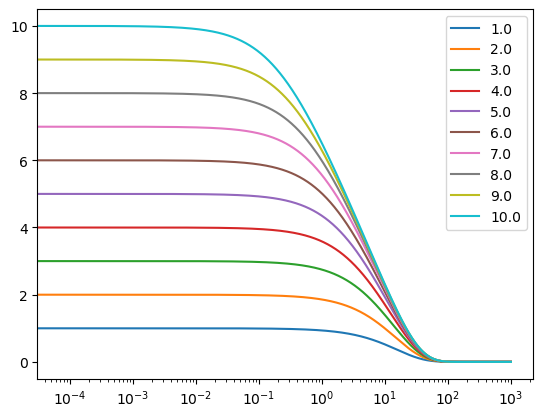

In [ ]:
V0s = np.linspace(1, 10, 10)
for V0 in V0s:
    phi = 4 * kTbye * np.atanh(np.tanh(V0/4/kTbye) * np.exp(-xdata_sorted/Ld))
    # cposexp = 1/c0 / (1 + 1/c0 * np.exp( 4 * kTbye * np.atanh(np.tanh(-V0/4/kTbye) * np.exp(-xdata_sorted/Ld)) / kTbye))
    x_value = xdata_sorted[np.argmax(phi <= np.max(phi) / np.e)]
    x_index = np.argmax(phi <= np.max(phi) / np.e)
    print(f"x value at which cposexp becomes 1/e times the maximum value for V0={V0}: {x_value}, at index: {x_index}")
    plt.plot(xdata_sorted, phi, label = V0)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

x value at which cposexp becomes 1/e times the maximum value for V0=-1.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-2.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-3.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-4.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-5.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-6.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-7.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-8.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-9.0: 0.0, at index: 0
x value at which cposexp becomes 1/e times the maximum value for V0=-10.0: 0.0, at index: 0


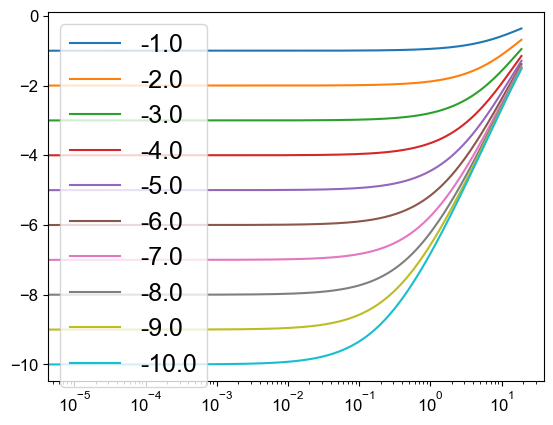

In [842]:
V0s = -np.linspace(1, 10, 10)
Ld = 19.0
for V0 in V0s:
    phi = 4 * kTbye * np.atanh(np.tanh(V0/4/kTbye) * np.exp(-xdata_sorted/Ld))
    # cposexp = 1/c0 / (1 + 1/c0 * np.exp( 4 * kTbye * np.atanh(np.tanh(-V0/4/kTbye) * np.exp(-xdata_sorted/Ld)) / kTbye))
    x_value = xdata_sorted[np.argmax(phi <= np.max(phi) / np.e)]
    x_index = np.argmax(phi <= np.max(phi) / np.e)
    print(f"x value at which cposexp becomes 1/e times the maximum value for V0={V0}: {x_value}, at index: {x_index}")
    plt.plot(xdata_sorted, phi, label = V0)
plt.xscale('log')
# plt.yscale('log')
plt.legend()